In [1]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec

from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='processed_data/dataset_customized.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

#Uncomment the following two lines if kaggle datasets is used...and replace data_df variable above with raw_data
#indexer = StringIndexer(inputCol="lable", outputCol="label")
#data_df = indexer.fit(raw_data).transform(raw_data).select("url", "label")

In [8]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#determing components to be removed in the URL
add_stopWords = ["http", "https", "www", "ftp"]

#Removing the above stop words  from the tokenized data
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="Filtered").setStopWords(add_stopWords)

#Convert the words to ngrams. Note: this is not used in production as it gives less results during model training
ngram = NGram(n=3, inputCol=stopwordsRemover.getOutputCol(), outputCol="Ngrams")

#Word2Vec - Note: this is not used in production as it gives less results during model training
word2Vec = Word2Vec(vectorSize=1000, minCount=5, inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

#Hashing the data - Note: this is not used in production as it gives less results during model training
hashingTF = HashingTF(inputCol=ngram.getOutputCol(), outputCol="rawFeatures")

#Note: this is not used in production as it gives less results during model training
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features") 

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=stopwordsRemover.getOutputCol(), outputCol="features", vocabSize=10000, minDF=5)

#creating the pipepline of steps to be performed in order
pipeline = Pipeline(stages=[regexTokenizer,stopwordsRemover, countVectors ])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data_df)

#Transform the pipeline to dataset
dataset = pipelineFit.transform(data_df)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))
dataset.show(truncate = 200)

Training Dataset Count: 957566
Test Dataset Count: 240580
Total Dataset Count: 1198146
+------------+-----+---------------+---------------+------------------------+
|         url|label|          Words|       Filtered|                features|
+------------+-----+---------------+---------------+------------------------+
|  0b55.top;1|    1| [0b55, top, 1]| [0b55, top, 1]|(10000,[2,37],[1.0,1.0])|
|  0dfd9x.net|    1|  [0dfd9x, net]|  [0dfd9x, net]|       (10000,[3],[1.0])|
|135cross.com|    1|[135cross, com]|[135cross, com]|       (10000,[0],[1.0])|
|     1ct.top|    1|     [1ct, top]|     [1ct, top]|      (10000,[37],[1.0])|
|     1gc.top|    1|     [1gc, top]|     [1gc, top]|      (10000,[37],[1.0])|
|     1gd.top|    1|     [1gd, top]|     [1gd, top]|      (10000,[37],[1.0])|
|   1nr.top;1|    1|  [1nr, top, 1]|  [1nr, top, 1]|(10000,[2,37],[1.0,1.0])|
|     1nz.top|    1|     [1nz, top]|     [1nz, top]|      (10000,[37],[1.0])|
|     1pn.top|    1|     [1pn, top]|     [1pn, top]|   

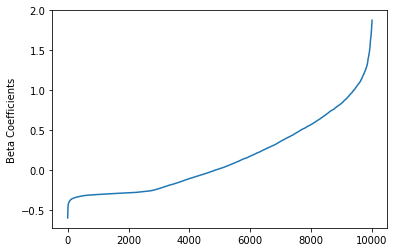

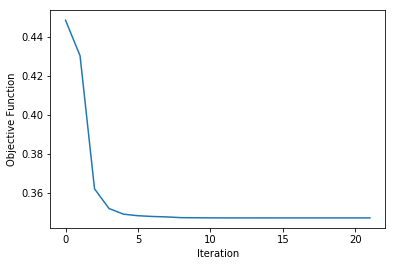

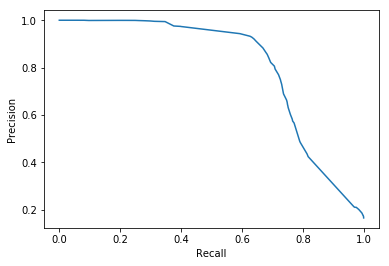

areaUnderROC: 0.8894553208125439


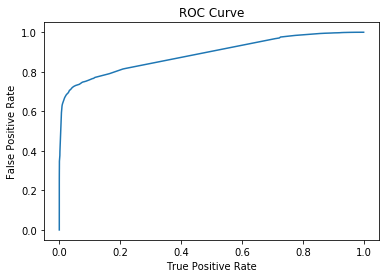

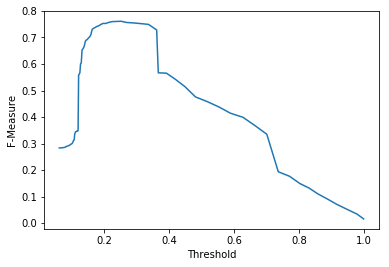

+-------------------------------------+-----+----------+
|                                  url|label|prediction|
+-------------------------------------+-----+----------+
|           0000mps.webpreview.dsl.net|    1|       0.0|
|                 000lkub.rcomhost.com|    1|       0.0|
|                 000ll4q.rcomhost.com|    1|       0.0|
|                 000lp59.wcomhost.com|    1|       0.0|
|00capital0neservice.000webhostapp.com|    1|       0.0|
+-------------------------------------+-----+----------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.342945

Accuracy on Test Data = 88.6032


In [18]:
#==============[ LOGISTIC REGRESSION ]=========================

# Build logistic regresssion model
lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model using logisitic regression
lrModel = lr.fit(trainingData)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

#Doing the prediction using test data
#Label is not used in test data
predictions = lrModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))


#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)

In [4]:
#==============[ Cross Validation for Logistic Regression ]=====================


# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Test: Area Under ROC: 0.9763079945884876


In [4]:
#==============[ Linear Support Vector Machine ]=====================


lsvc = LinearSVC(maxIter=10, regParam=0.3)

# Fit the model
lsvcModel = lsvc.fit(trainingData)

predictions = lsvcModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))

+-------------------------------------+-----+----------+
|                                  url|label|prediction|
+-------------------------------------+-----+----------+
|           0000mps.webpreview.dsl.net|    1|       0.0|
|                 000lkub.rcomhost.com|    1|       0.0|
|                 000ll4q.rcomhost.com|    1|       0.0|
|                 000lp59.wcomhost.com|    1|       0.0|
|00capital0neservice.000webhostapp.com|    1|       1.0|
+-------------------------------------+-----+----------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.266847

Accuracy on Test Data = 86.9554


In [5]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

evaluator1 = BinaryClassificationEvaluator()

predictions.select("url", "label", "prediction").show(n=5, truncate = 100)


# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("\nAccuracy on Test Data = %g" % (accuracy*100))


+-------------------------------------+-----+----------+
|                                  url|label|prediction|
+-------------------------------------+-----+----------+
|           0000mps.webpreview.dsl.net|    1|       0.0|
|                 000lkub.rcomhost.com|    1|       0.0|
|                 000ll4q.rcomhost.com|    1|       0.0|
|                 000lp59.wcomhost.com|    1|       1.0|
|00capital0neservice.000webhostapp.com|    1|       1.0|
+-------------------------------------+-----+----------+
only showing top 5 rows

Test Error = 0.0689667

Accuracy on Test Data = 93.1033
